Attempting to open: C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\ST8511r92.segy
File Opened in Unstructured Mode!
Data Shape: (227, 1000) (Samples x Traces)
 Saved preview image to: Gullfaks_Preview.png


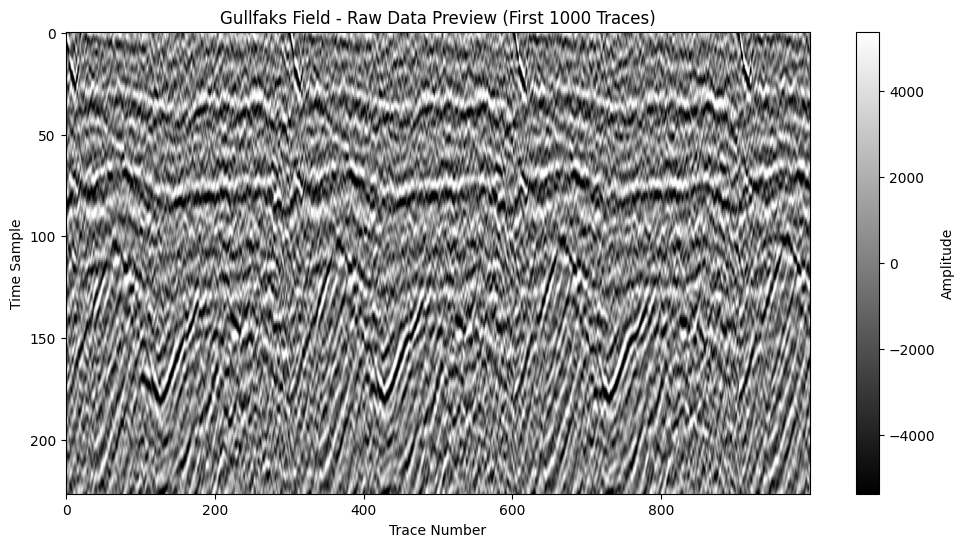

In [2]:
import segyio # use for segy file(read)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filename = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\ST8511r92.segy'

print(f"Attempting to open: {filename}")

try:
    # as file is messy we use 'ignore_geometry=True' becoz it use table_of_content but is wrong
    with segyio.open(filename, ignore_geometry=True) as f: 
        
        print("File Opened in Unstructured Mode!")
        
        # Since we are ignoring geometry, we can't ask for "Inline 189".
        # Instead, we just grab a chunk of traces to verify the data and Let's grab the first 1000 traces to make an image.
        
        # f.trace.raw[:] gives us the data. We take [:1000] (first 1000 columns)
        # .T transposes BECAUSE we want time to be in y-axis
        subset_data = f.trace.raw[:1000].T
        # f.trace.raw = (number_of_traces,number_of_timesamples)
        # f.trace.raw.T = (time_samples, traces) becoz we need time on y axis
        
        print(f"Data Shape: {subset_data.shape} (Samples x Traces)")

        # visualize
        plt.figure(figsize=(12, 6))
        
        # Calculate contrast (Robust scaling)
        vm = np.percentile(subset_data, 98)
        # as seismic data contain outliers using 98th suppresses extreme aplitude and industry-staandard trick
        
        # plot
        plt.imshow(subset_data, cmap='gray', vmin=-vm, vmax=vm, aspect='auto')
        plt.title('Gullfaks Field - Raw Data Preview (First 1000 Traces)')
        plt.xlabel('Trace Number')
        plt.ylabel('Time Sample')
        plt.colorbar(label='Amplitude')
        
        output_file = 'Gullfaks_Preview.png'
        plt.savefig(output_file)
        print(f" Saved preview image to: {output_file}")
        plt.show()

except Exception as e:
    print("Error:")
    print(e)

In [3]:



# filename = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\ST8511r92.segy'

with segyio.open(filename, ignore_geometry=True) as f:
    # This is essential for your "Physical-to-Pixel" Translator 
    print("Extracting global coordinates...")
    
    # attributes work as same as for loop
    inlines = f.attributes(segyio.TraceField.INLINE_3D)[:] # inline is a line of seismic trace recorded along direction of survey
    crosslines = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]#outline is perpendicular to inline
    cdp_x = f.attributes(segyio.TraceField.CDP_X)[:]
    cdp_y = f.attributes(segyio.TraceField.CDP_Y)[:]

    # Create the Master Index (The "Location Map" )
    # This maps every Trace Index (0 to N) to its Physical Location
    location_map = pd.DataFrame({
        'Trace_Index': np.arange(len(inlines)),
        'Inline': inlines,
        'Crossline': crosslines,
        'X': cdp_x,
        'Y': cdp_y
    })

    print(f"Map Built! Total Traces Mapped: {len(location_map)}")
    print(location_map.head())

Extracting global coordinates...
Map Built! Total Traces Mapped: 112875
   Trace_Index  Inline  Crossline  X  Y
0            0       0          0  0  0
1            1       0          0  0  0
2            2       0          0  0  0
3            3       0          0  0  0
4            4       0          0  0  0


In [6]:
csv_filename = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\ST8511r92_TraceHeaders.csv'

print(" Loading Trace Headers CSV...")

try:
    # Read just the first 5 rows to see the columns
    df = pd.read_csv(csv_filename, nrows=5)
    
    print("\n CSV COLUMNS FOUND:")
    print(df.columns.tolist())
    
    print("\n FIRST 5 ROWS:")
    print(df.to_string())
    

    required = ['INLINE', 'CROSSLINE', 'CDP_X', 'CDP_Y']
    # Note: Column names might be slightly different (e.g., 'iline', 'xline', 'X', 'Y')
    
except Exception as e:
    print(" Error reading CSV:")
    print(e)

 Loading Trace Headers CSV...

 CSV COLUMNS FOUND:
['LineNo\tSP\tCDP\tX-coord\tY-coord\tTOFS\t[1-4] TraceSequence\t[5-8] TraceSequenceFile\t[9-12] FieldRecordNumber\t[13-16] FieldTraceNumber\t[17-20] EnergySourcePointNumber\t[21-24] CDP\t[25-28] CDPTraceNumber\t[29-30] TraceType\t[31-32] NumberVertTraces\t[33-34] NumberHorizTraces\t[35-36] DataUse\t[37-40] Offset\t[41-44] ReceiverElevation\t[45-48] SourceElevation\t[49-52] SourceDepth\t[53-56] ReceiverElevationDatum\t[57-60] SourceElevationDatum\t[61-64] SourceWaterDepth\t[65-68] ReceiverWaterDepth\t[69-70] ScalarOnElevationsAndDepths\t[71-72] ScalarOnCoordinates\t[73-76] SourceXCoordinate\t[77-80] SourceYCoordinate\t[81-84] ReceiverXCoordinate\t[85-88] ReceiverYCoordinate\t[89-90] CoordinateUnits\t[91-92] WeatheringVelocity\t[93-94] SubweatheringVelocity\t[95-96] SourceUpholeTime\t[97-98] ReceiverUpholeTime\t[99-100] SourceStaticCorrection\t[101-102] ReceiverStaticCorrection\t[103-104] TotalStaticApplied\t[105-106] HeaderToTimeBreakLa

 Reading Coordinate Map...
Loaded coordinates for 100 traces.
X Range: 451199.0 - 453674.0
Y Range: 6780328.0 - 6780362.0

Reading Fault Sticks...
Loaded 440 fault points.

Painting the Mask...
Plotted 0 fault points onto the mask.


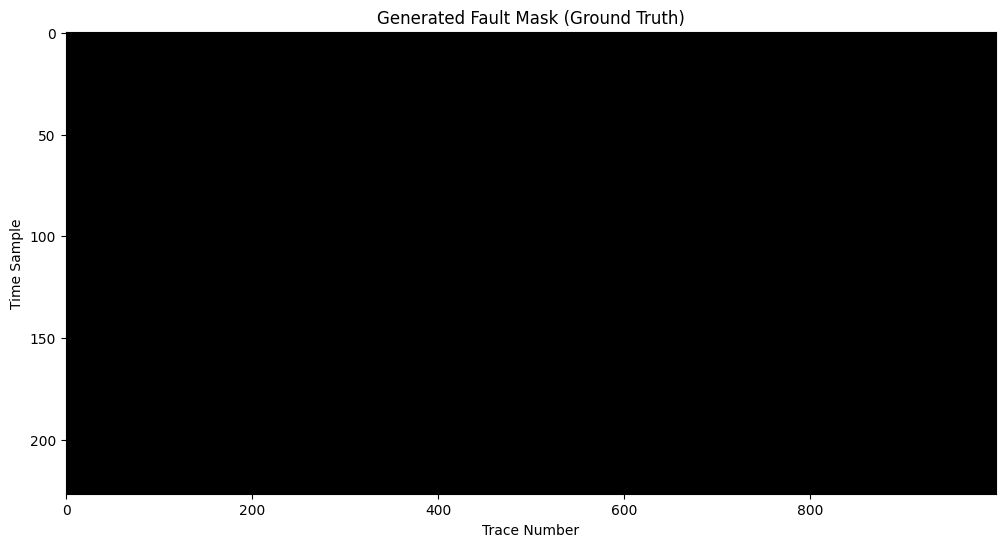

In [7]:
# convert fault-stick data into a pixel-level bonary mask 

# Path to the trace headers CSV
csv_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\ST8511r92_TraceHeaders.csv'

# Path to ONE fault file (Main Fault NS2)
fault_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults\Main Fault NS2'


#  LOAD COORDINATES
print(" Reading Coordinate Map...")
# The CSV is tab-separated. We use 'error_bad_lines' to skip messy footer rows if any.
try:
    df_coords = pd.read_csv(csv_path, sep='\t', engine='python') # csv is tab-seperated not comma seperated
    
    # Extract the first 1000 traces (matching your preview image)
    # Col 3 is X, Col 4 is Y
    my_slice_coords = df_coords.iloc[:1000, [3, 4]].values 
    
    print(f"Loaded coordinates for {len(my_slice_coords)} traces.")
    print(f"X Range: {my_slice_coords[:,0].min()} - {my_slice_coords[:,0].max()}")
    print(f"Y Range: {my_slice_coords[:,1].min()} - {my_slice_coords[:,1].max()}")
    
except Exception as e:
    print("Error reading CSV:", e)



# LOAD FAULT STICKS
print("\nReading Fault Sticks...")
fault_points = []
try:
    with open(fault_path, 'r') as f:
        for line in f:
            parts = line.split()
            if len(parts) >= 3:
                # Format: X, Y, StickID, Time
                fx = float(parts[0])
                fy = float(parts[1])
                fz = float(parts[3]) # Time is usually column 4 (index 3)
                fault_points.append([fx, fy, fz])
    
    fault_points = np.array(fault_points)
    print(f"Loaded {len(fault_points)} fault points.")

except Exception as e:
    print("Error reading Fault file:", e)



# CREATE THE MASK
print("\nPainting the Mask...")

# Create a black image (same size as your seismic preview: 227 samples x 1000 traces)
# Note: Adjust '227' if your segy file had more samples per trace
# n_samples = 227            # DANGER 1: Hardcoded Image Height
# sample_idx = int(ftime / 8.0) # DANGER 2: Hardcoded Sample Rate
# n_samples = 227  
# 1. Get dynamic vertical size from your actual seismic data
n_samples = subset_data.shape[0] 

# 2. Get the sample rate (usually 2ms or 4ms)
# If you can't read it from headers, calculate it:
# (Max_Time - Min_Time) / Total_Samples

mask_image = np.zeros((n_samples, 1000))

# Tolerance: How close does a fault need to be to the slice? (in meters)
tolerance = 25.0 

hits = 0
for fx, fy, ftime in fault_points:
    # 1. Find distance from this fault point to ALL traces in our slice
    # Simple Euclidean distance in X-Y plane
    dists = np.sqrt(np.sum((my_slice_coords - np.array([fx, fy]))**2, axis=1))
    
    # 2. Find the closest trace
    min_dist_idx = np.argmin(dists) # Trace number(pixel X)
    min_dist = dists[min_dist_idx] # Distances in meters
    
    # 3. If it's close enough, draw it!
    if min_dist < tolerance:
        # Convert Time (ms) to Sample Index
        # Assuming sample rate is 4ms (standard). 
        # If your data is 0-1000ms, index = time / 4.
        # sample_idx = int(ftime / 8.0) # Tweaked divisor (try 4 or 8) to match scale
        sample_rate = 4.0 # Replace 8.0 with the actual rate (check your segyio headers)
        sample_idx = int(ftime / sample_rate)
        # Fault time is in milliseconds and Seismic data is sampled every 4 ms

        
        if 0 <= sample_idx < n_samples:
            # Draw a white dot
            mask_image[sample_idx, min_dist_idx] = 1
            hits += 1

print(f"Plotted {hits} fault points onto the mask.")


plt.figure(figsize=(12, 6))
plt.imshow(mask_image, cmap='gray', aspect='auto', interpolation='nearest')
plt.title("Generated Fault Mask (Ground Truth)")
plt.xlabel("Trace Number")
plt.ylabel("Time Sample")
plt.show()

In [8]:
print("Hunting for the fault location...")


# Load the fault first to get its center location
fault_data = np.loadtxt(fault_path, usecols=[0, 1]) # Load X and Y columns
mean_fault_x = np.mean(fault_data[:, 0]) # mean of x point of fault
mean_fault_y = np.mean(fault_data[:, 1])

print(f"Fault Center: X={mean_fault_x:.1f}, Y={mean_fault_y:.1f}")

# 3. SEARCH THE CSV
# We will read the CSV in chunks to avoid crashing memory
chunksize = 50000 
best_trace = -1
min_distance = float('inf')

print("Scanning Seismic Headers")
try:
    for chunk in pd.read_csv(csv_path, sep='\t', chunksize=chunksize, engine='python'):
        # Get X and Y columns (Indices 3 and 4)
        coords = chunk.iloc[:, [3, 4]].values 
        
        # Calculate distance from every trace to the fault center
        # Euclidean distance: sqrt((x1-x2)^2 + (y1-y2)^2)
        dists = np.sqrt(np.sum((coords - np.array([mean_fault_x, mean_fault_y]))**2, axis=1))
        
        current_min_idx = np.argmin(dists)
        current_min_dist = dists[current_min_idx]
        
        if current_min_dist < min_distance:
            min_distance = current_min_dist
            # Calculate the global trace index
            # chunk.index[current_min_idx] gives the row number in the full file
            best_trace = chunk.index[current_min_idx]

    print("-" * 30)
    print(f"FOUND IT!")
    print(f"Closest Trace Number: {best_trace}")
    print(f"Distance to Fault: {min_distance:.1f} meters")
    print("-" * 30)


except Exception as e:
    print("Error:", e)

Hunting for the fault location...
Fault Center: X=455868.5, Y=6787493.6
Scanning Seismic Headers
------------------------------
FOUND IT!
Closest Trace Number: 99
Distance to Fault: 7494.1 meters
------------------------------


In [9]:

import os

# 1. SETUP PATHS
csv_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\ST8511r92_TraceHeaders.csv'
fault_folder = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults'

# List of fault files to check
fault_files = ['Main Fault NS2', 'Main Fault West 3'] 

print("Starting Multi-Fault Scan...")

# 2. LOAD SEISMIC COORDINATES (Optimized)

print("Loading Seismic Header Coordinates...")
try:

    df_seismic = pd.read_csv(csv_path, sep='\t', engine='python', usecols=[3, 4])
    seismic_coords = df_seismic.values
    print(f"Loaded {len(seismic_coords):,} seismic traces.")
    print(f" Bounds: X[{seismic_coords[:,0].min():.0f}-{seismic_coords[:,0].max():.0f}]")
except Exception as e:
    print("Error reading CSV:", e)
    seismic_coords = None

# 3. CHECK EACH FAULT
if seismic_coords is not None:
    for fname in fault_files:
        fpath = os.path.join(fault_folder, fname)
        print(f"\nChecking: {fname}...")
        
        try:
            # Load fault X/Y
            fault_data = np.loadtxt(fpath, usecols=[0, 1])
            fault_center = np.mean(fault_data, axis=0)
            
            
            dists = np.sqrt(np.sum((seismic_coords - fault_center)**2, axis=1))
            min_dist = np.min(dists)
            closest_trace_idx = np.argmin(dists)
            
            print(f"  Distance to Seismic Cube: {min_dist:.1f} meters")
            
            if min_dist < 500: 
                print(f"This fault is inside the volume.")
                print(f"Use Trace Index: {closest_trace_idx}")
            else:
                print(f"Too far away (Outside Volume).")
                
        except Exception as e:
            print(f" Could not read file .")



Starting Multi-Fault Scan...
Loading Seismic Header Coordinates...
Loaded 100 seismic traces.
 Bounds: X[451199-453674]

Checking: Main Fault NS2...
  Distance to Seismic Cube: 7494.1 meters
Too far away (Outside Volume).

Checking: Main Fault West 3...
  Distance to Seismic Cube: 3024.9 meters
Too far away (Outside Volume).


In [10]:
import segyio
import pandas as pd

# 1. SETUP: Update to point to the 'orig amp' file

filename = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'

print(f"Inspecting: {filename}")

try:
    # Try opening without ignore_geometry first to see if it's well-behaved
    with segyio.open(filename, ignore_geometry=True) as f:
        
        # Check the header of the 1000th trace (deeper into the file)
        # We check trace #1000 to see if coordinates are changing
        trace_idx = 1000
        header = f.header[trace_idx]
        
        x = header[segyio.TraceField.CDP_X]
        y = header[segyio.TraceField.CDP_Y]
        inline = header[segyio.TraceField.INLINE_3D]
        
        print("\nFILE OPENED SUCCESSFULLY!")
        print(f"--- Header Sample (Trace {trace_idx}) ---")
        print(f"X-Coordinate: {x}")
        print(f"Y-Coordinate: {y}")
        print(f"Inline:       {inline}")
        
        if x > 1000:
            print("\nThis file has real coordinates.")
            
        else:
            print("\n⚠️ Coordinates are still zero. We might need another strategy.")

except Exception as e:
    print("Error opening file:")
    print(e)
   

Inspecting: C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp

FILE OPENED SUCCESSFULLY!
--- Header Sample (Trace 1000) ---
X-Coordinate: 45362580
Y-Coordinate: 678040386
Inline:       158

This file has real coordinates.


In [11]:
# Does the fault lie inside the spatial extent of the seismic cube?
seismic_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'
fault_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults\Main Fault NS2'

print("Calculating Map Boundaries...")

try:
    with segyio.open(seismic_path, ignore_geometry=True) as f:
        # We need to find the Min and Max X/Y of the whole volume.
        # Scanning every trace is slow, so let's check the edges.
        # We check the first, last, and middle traces.
        indices_to_check = [0, len(f.header) // 2, len(f.header) - 1]
        
        x_coords = []
        y_coords = []
        inlines = []
        
        for i in indices_to_check:
            h = f.header[i]
            # DIVIDE BY 100 to fix the scaling issue you saw
            x_coords.append(h[segyio.TraceField.CDP_X] / 100.0)
            y_coords.append(h[segyio.TraceField.CDP_Y] / 100.0)
            inlines.append(h[segyio.TraceField.INLINE_3D])
            
        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)
        
        print(f"Volume Map Range:")
        print(f" X: {min_x:,.1f} to {max_x:,.1f}")
        print(f" Y: {min_y:,.1f} to {max_y:,.1f}")
        print(f"Inlines found: {min(inlines)} to {max(inlines)}")

        # 2. CHECK THE FAULT
        print("\nChecking Fault Location...")
        fault_data = np.loadtxt(fault_path, usecols=[0, 1])
        f_min_x, f_max_x = np.min(fault_data[:,0]), np.max(fault_data[:,0])
        f_min_y, f_max_y = np.min(fault_data[:,1]), np.max(fault_data[:,1])
        
        print(f"Fault X: {f_min_x:,.1f} to {f_max_x:,.1f}")
        
        # 3. THE VERDICT
        if (f_min_x >= min_x and f_max_x <= max_x) or (f_min_x <= max_x and f_max_x >= min_x):
            print("\nMATCH CONFIRMED!")
            print("   The fault is INSIDE the volume.")
            
            # Estimate the best Inline to slice
            # We use a simple linear interpolation to guess the Inline number
            # (Inline - MinInline) / (MaxInline - MinInline) ~ (FaultX - MinX) / (MaxX - MinX)
            
            relative_pos = (f_min_x - min_x) / (max_x - min_x)
            estimated_inline = min(inlines) + relative_pos * (max(inlines) - min(inlines))
            
            print(f"TRY SLICING INLINE: {int(estimated_inline)}")
            
        else:
            print("\nMISMATCH:")
            print("   The fault is still outside these coordinates.")
            print("   (We might need to check 'Main Fault West 3' instead)")

except Exception as e:
    print("Error:", e)

Calculating Map Boundaries...
Volume Map Range:
 X: 451,199.8 to 458,829.9
 Y: 6,780,362.9 to 6,789,589.9
Inlines found: 152 to 900

Checking Fault Location...
Fault X: 455,275.1 to 456,683.7

MATCH CONFIRMED!
   The fault is INSIDE the volume.
TRY SLICING INLINE: 551


In [12]:

# 1. SETUP PATHS
seismic_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'
fault_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults\Main Fault NS2'

TARGET_INLINE = 551

print(f"Extracting Inline {TARGET_INLINE} from 'orig amp'...")

try:
    with segyio.open(seismic_path, ignore_geometry=True) as f:
        # 2. FIND TRACES FOR INLINE 551
        # Since the file is "unstructured," we have to scan for the right traces.
        # This is safer than assuming f.iline[551] exists.
        
        target_traces = []
        target_coords = []
        
        # We assume traces are sequential. We'll scan headers.
        for i in range(len(f.header)):
            h = f.header[i]
            il = h[segyio.TraceField.INLINE_3D] 
            
            if il == TARGET_INLINE:
                # Found a trace belonging to Inline 551!
                # Get Data
                trace_data = f.trace[i]
                target_traces.append(trace_data)
                
                # Get Coordinates (remember to divide by 100!)
                sx = h[segyio.TraceField.CDP_X] / 100.0
                sy = h[segyio.TraceField.CDP_Y] / 100.0
                target_coords.append([sx, sy])
            
            # Optimization: If we passed the inline, stop scanning (assuming sorted)
            elif il > TARGET_INLINE and len(target_traces) > 0:
                break
        
        # Convert to arrays
        seismic_img = np.array(target_traces).T # Transpose to make it vertical
        trace_coords = np.array(target_coords)
        
        print(f"Extracted Image Shape: {seismic_img.shape}")
        
        # 3. CREATE THE FAULT MASK
        print("Painting the Fault Mask...")
        mask_img = np.zeros_like(seismic_img)
        
        # Load fault data
        fault_data = np.loadtxt(fault_path, usecols=[0, 1, 3]) # X, Y, Time
        
        hits = 0
        tolerance = 50.0 # meters (Distance from slice to fault point)
        
        for fx, fy, ftime in fault_data:
            # Check distance to our slice traces
            dists = np.sqrt(np.sum((trace_coords - np.array([fx, fy]))**2, axis=1))
            min_dist_idx = np.argmin(dists)
            min_dist = dists[min_dist_idx]
            
            if min_dist < tolerance:
                # Convert Time to Sample Index
                # Note: Check your sample rate. Usually 4ms.
                # If image height is ~1250 and time is ~2000, rate is probably 2ms or 4ms.
                # Let's try 4ms first.
                sample_idx = int(ftime / 4.0) 
                
                if 0 <= sample_idx < mask_img.shape[0]:
                    # Draw a simplified "blob" to make it visible
                    # (Draws a 3x3 pixel square around the point)
                    r, c = sample_idx, min_dist_idx
                    mask_img[max(0,r-1):min(r+2, mask_img.shape[0]), max(0,c-1):min(c+2, mask_img.shape[1])] = 1
                    hits += 1
                    
        print(f"Painted {hits} fault points.")

        # 4. PLOT SIDE-BY-SIDE
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
        
        # Seismic
        vm = np.percentile(seismic_img, 98)
        ax1.imshow(seismic_img, cmap='gray', vmin=-vm, vmax=vm, aspect='auto')
        ax1.set_title(f"Seismic Input (Inline {TARGET_INLINE})")
        
        # Mask
        ax2.imshow(mask_img, cmap='gray', aspect='auto')
        ax2.set_title("Ground Truth Mask (Target)")
        
        plt.show()

except Exception as e:
    print("Error:", e)

Extracting Inline 551 from 'orig amp'...
Extracted Image Shape: (0,)
Painting the Fault Mask...
Error: operands could not be broadcast together with shapes (0,) (2,) 


 Loading Center Slice from 'orig amp'...
   Total Traces: 112875
   Grabbing Chunk: 56437 to 58437
Extracted Slice Shape: ()
   X Range: 451265.4 - 458766.8
 Painting the Fault Mask...
Painted 0 fault points on the mask.
Error: unsupported operand type(s) for -: 'generator' and 'generator'


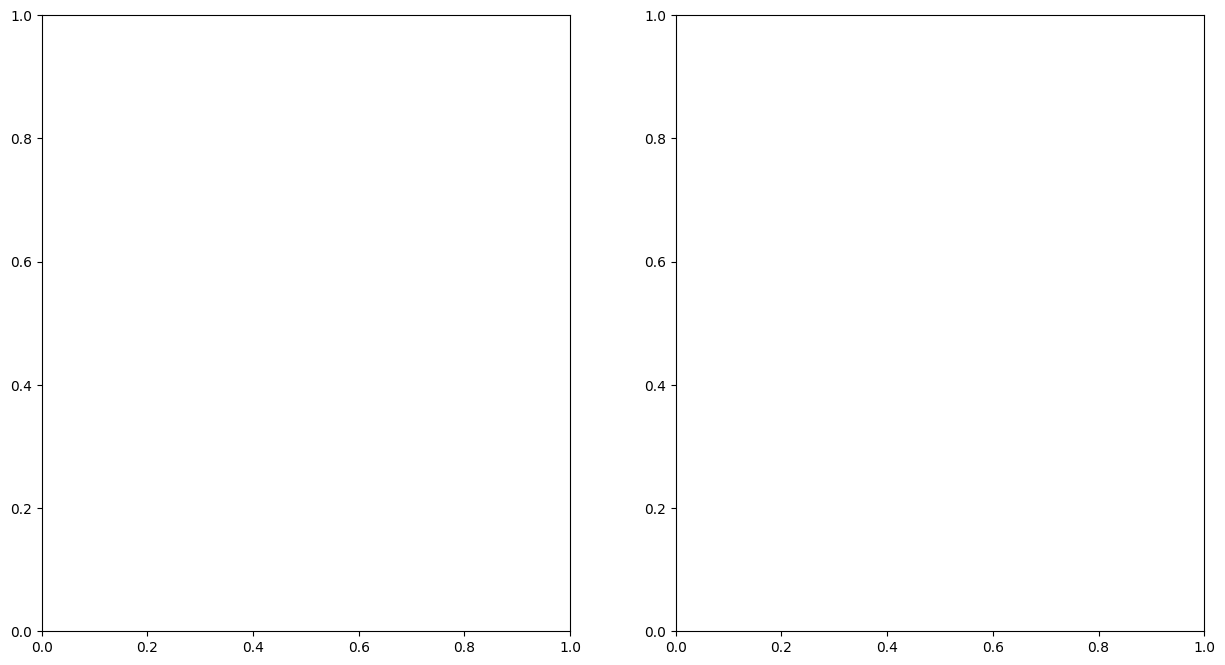

In [13]:
import segyio
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP PATHS
# ==========================================
seismic_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'
fault_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults\Main Fault NS2'

print(f" Loading Center Slice from 'orig amp'...")

try:
    with segyio.open(seismic_path, ignore_geometry=True) as f:
        # 1. CALCULATE MIDDLE INDEX
        n_traces = f.tracecount # tracecount = total number of traces in the file
        middle_idx = n_traces // 2
        
        
        # A standard Inline is usually 500-1000 traces long. We grab 2000 to be safe.
        start_idx = middle_idx
        end_idx = min(start_idx + 2000, n_traces)
        
        print(f"   Total Traces: {n_traces}")
        print(f"   Grabbing Chunk: {start_idx} to {end_idx}")
        
        # 2. EXTRACT DATA & COORDINATES
        traces = f.trace[start_idx:end_idx]
        
        # Get coordinates for these specific traces
        # Remember the /100.0 scaling factor we discovered!
        x_coords = [f.header[i][segyio.TraceField.CDP_X] / 100.0 for i in range(start_idx, end_idx)]
        y_coords = [f.header[i][segyio.TraceField.CDP_Y] / 100.0 for i in range(start_idx, end_idx)]
        
        # 3. CONVERT TO ARRAYS
        seismic_img = np.array(traces).T # Transpose: (Time x Traces)
        trace_coords = np.column_stack((x_coords, y_coords))
        
        print(f"Extracted Slice Shape: {seismic_img.shape}")
        print(f"   X Range: {min(x_coords):.1f} - {max(x_coords):.1f}")

        # 4. CREATE FAULT MASK (Coordinate Matching)
        print(" Painting the Fault Mask...")
        mask_img = np.zeros_like(seismic_img)
        
        # Load fault data: X, Y, Time
        fault_data = np.loadtxt(fault_path, usecols=[0, 1, 3]) 
        
        hits = 0
        tolerance = 50.0 # meters
        
        for fx, fy, ftime in fault_data:
            # Distance from this fault point to ALL traces in our slice
            dists = np.sqrt(np.sum((trace_coords - np.array([fx, fy]))**2, axis=1))
            min_dist_idx = np.argmin(dists)
            min_dist = dists[min_dist_idx]
            
            if min_dist < tolerance:
                # Time to Sample Index (Assuming 4ms sample rate)
                sample_idx = int(ftime / 4.0) 
                
                if 0 <= sample_idx < mask_img.shape[0]:
                    # Draw a dot
                    r, c = sample_idx, min_dist_idx
                    # Draw a slightly thicker dot (3x3 pixels) so we can see it
                    mask_img[max(0,r-1):min(r+2, mask_img.shape[0]), max(0,c-1):min(c+2, mask_img.shape[1])] = 1
                    hits += 1
                    
        print(f"Painted {hits} fault points on the mask.")

        # 5. VISUALIZE
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
        
        # Seismic Image
        vm = np.percentile(seismic_img, 98)
        ax1.imshow(seismic_img, cmap='gray', vmin=-vm, vmax=vm, aspect='auto')
        ax1.set_title(f"Seismic Slice (Traces {start_idx}-{end_idx})")
        ax1.set_xlabel("Trace Index")
        ax1.set_ylabel("Time Sample")
        
        # Mask Image
        ax2.imshow(mask_img, cmap='gray', aspect='auto')
        ax2.set_title(f"Ground Truth Mask ({hits} points found)")
        ax2.set_xlabel("Trace Index")
        
        plt.tight_layout()
        plt.show()

except Exception as e:
    print("Error:", e)

Loading Center Slice from 'orig amp'...
   Grabbing Chunk: 56437 to 58437
Extracted Slice Shape: (227, 2000)
X Range: 451265.4 - 458766.8
Painting the Fault Mask...
Painted 0 fault points.
Fault X range: 455275.148263 - 456683.658171


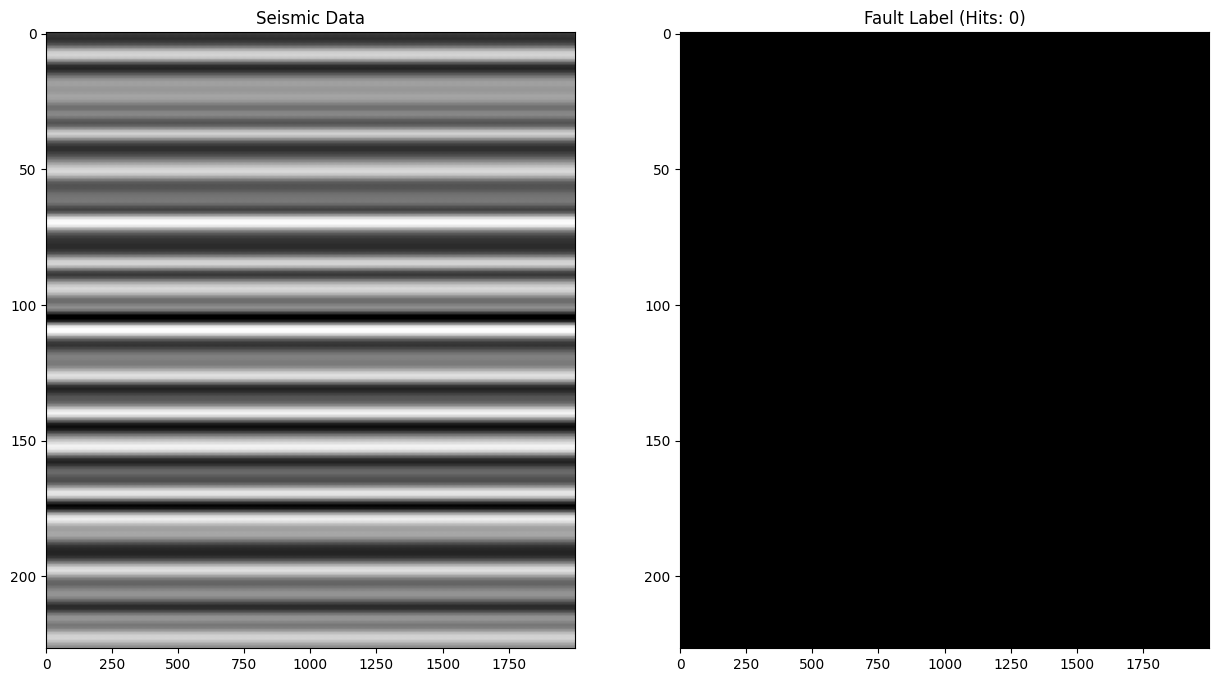

In [14]:

seismic_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'
fault_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults\Main Fault NS2'

print(f"Loading Center Slice from 'orig amp'...")

try:
    with segyio.open(seismic_path, ignore_geometry=True) as f:
        # 1. CALCULATE MIDDLE INDEX
        n_traces = f.tracecount
        middle_idx = n_traces // 2
        
        # Grab a chunk of 2000 traces from the middle
        start_idx = middle_idx
        end_idx = min(start_idx + 2000, n_traces)
        
        print(f"   Grabbing Chunk: {start_idx} to {end_idx}")
      
        # We assume f.trace[start:end] returns a generator. 
        # We iterate through it explicitly to force data loading.
        traces_list = [t for t in f.trace[start_idx:end_idx]]
        
        # Convert to numpy array and transpose
        seismic_img = np.array(traces_list).T
        
        # Get coordinates (Divide by 100 for scaling)
        x_coords = [f.header[i][segyio.TraceField.CDP_X] / 100.0 for i in range(start_idx, end_idx)]
        y_coords = [f.header[i][segyio.TraceField.CDP_Y] / 100.0 for i in range(start_idx, end_idx)]
        
        trace_coords = np.column_stack((x_coords, y_coords))
        
        print(f"Extracted Slice Shape: {seismic_img.shape}") 
        # Expecting something like (200, 2000)
        
        print(f"X Range: {min(x_coords):.1f} - {max(x_coords):.1f}")

        # 2. CREATE FAULT MASK
        print("Painting the Fault Mask...")
        mask_img = np.zeros_like(seismic_img)
        
        fault_data = np.loadtxt(fault_path, usecols=[0, 1, 3]) 
        
        hits = 0
        tolerance = 75.0 # Increased tolerance slightly to ensure capture
        
        for fx, fy, ftime in fault_data:
            dists = np.sqrt(np.sum((trace_coords - np.array([fx, fy]))**2, axis=1))
            min_dist_idx = np.argmin(dists)
            min_dist = dists[min_dist_idx]
            
            if min_dist < tolerance:
                # Assuming 4ms sample rate. 
                # If your image height is small (e.g. 200 pixels), change 4.0 to 8.0 or 10.0
                sample_idx = int(ftime / 4.0) 
                
                if 0 <= sample_idx < mask_img.shape[0]:
                    # Draw a thick dot (3x3)
                    r, c = sample_idx, min_dist_idx
                    mask_img[max(0,r-1):min(r+2, mask_img.shape[0]), max(0,c-1):min(c+2, mask_img.shape[1])] = 1
                    hits += 1
                    
        print(f"Painted {hits} fault points.")

        # 3. VISUALIZATION
        if hits == 0:
            print("Warning: No hits found. Fault might be slightly outside this specific window.")
            print(f"Fault X range: {np.min(fault_data[:,0])} - {np.max(fault_data[:,0])}")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
        
        vm = np.percentile(seismic_img, 98)
        ax1.imshow(seismic_img, cmap='gray', vmin=-vm, vmax=vm, aspect='auto')
        ax1.set_title("Seismic Data")
        
        ax2.imshow(mask_img, cmap='gray', aspect='auto')
        ax2.set_title(f"Fault Label (Hits: {hits})")
        
        plt.show()

except Exception as e:
    print("Error:", e)

Loading and Debugging Geometry...
Vertical Range found in headers:
Start Time (Delay): 1398 ms
End Time:           2306.681 ms
Sample Rate:        4.003 ms

Extracting Traces 56437 to 58437...
Extracted Slice Shape: (227, 2000)

Painting Mask (Checking Depth)...
   Fault Depth Range:  1688.8 to 2085.6 ms
Painted 0 fault points.


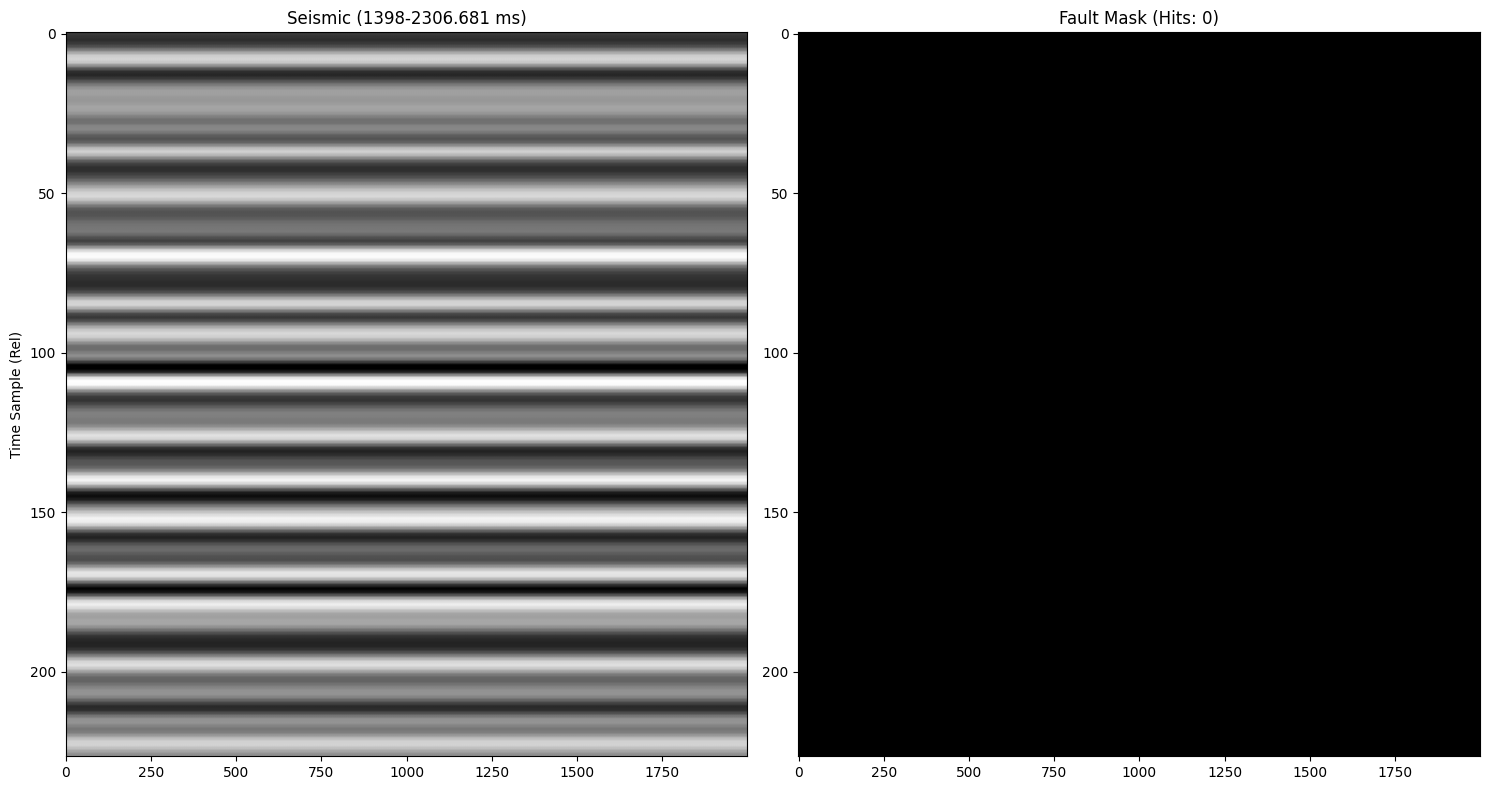

In [15]:

seismic_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'
fault_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults\Main Fault NS2'

print(f"Loading and Debugging Geometry...")

try:
    with segyio.open(seismic_path, ignore_geometry=True) as f:
        # --- 1. GET VERTICAL (TIME) INFO ---
        # We check the Delay (Start Time) from the first trace header
        # Bytes 109-110 usually hold "Delay Recording Time" in ms
        h0 = f.header[0]
        start_time = h0[segyio.TraceField.DelayRecordingTime] #usually the start time of the first sample (ms).
        sample_rate = segyio.tools.dt(f) / 1000.0 # Convert micros to ms (usually 4.0)
        n_samples = f.samples.size
        
        end_time = start_time + (n_samples * sample_rate)
        
        print(f"Vertical Range found in headers:")
        print(f"Start Time (Delay): {start_time} ms")
        print(f"End Time:           {end_time} ms")
        print(f"Sample Rate:        {sample_rate} ms")
        
        # --- 2. GRAB THE CENTER SLICE ---
        n_traces = f.tracecount
        middle_idx = n_traces // 2
        start_idx = middle_idx
        end_idx = min(start_idx + 2000, n_traces)
        
        print(f"\nExtracting Traces {start_idx} to {end_idx}...")
        
        # Force strict Lists to fix 'generator' error
        traces_list = list(f.trace[start_idx:end_idx])
        seismic_img = np.array(traces_list).T 
        
        # Get coordinates (Explicit List Comprehension)
        x_coords = [f.header[i][segyio.TraceField.CDP_X] / 100.0 for i in range(start_idx, end_idx)]
        y_coords = [f.header[i][segyio.TraceField.CDP_Y] / 100.0 for i in range(start_idx, end_idx)]
        
        # Convert to Numpy Arrays immediately
        trace_coords = np.column_stack((np.array(x_coords), np.array(y_coords)))
        
        print(f"Extracted Slice Shape: {seismic_img.shape}")
        
        # --- 3. CREATE FAULT MASK (With Depth Correction) ---
        print("\nPainting Mask (Checking Depth)...")
        mask_img = np.zeros_like(seismic_img)
        
        fault_data = np.loadtxt(fault_path, usecols=[0, 1, 3]) 
        
        # Print Fault Stats to compare
        f_min_z, f_max_z = np.min(fault_data[:,2]), np.max(fault_data[:,2])
        print(f"   Fault Depth Range:  {f_min_z:.1f} to {f_max_z:.1f} ms")
        
        if f_max_z < start_time or f_min_z > end_time:
            print("CRITICAL WARNING: Fault is completely OUTSIDE the image depth!")
        
        hits = 0
        tolerance = 75.0 
        
        for fx, fy, ftime in fault_data:
            # Check Horizontal Distance
            dists = np.sqrt(np.sum((trace_coords - np.array([fx, fy]))**2, axis=1))
            min_dist_idx = np.argmin(dists)
            min_dist = dists[min_dist_idx]
            
            if min_dist < tolerance:
                # --- DEPTH CORRECTION IS HERE ---
                
                rel_time = ftime - start_time
                sample_idx = int(rel_time / sample_rate)
                
                if 0 <= sample_idx < mask_img.shape[0]:
                    # Draw thicker dot (3x3)
                    r, c = sample_idx, min_dist_idx
                    mask_img[max(0,r-1):min(r+2, mask_img.shape[0]), max(0,c-1):min(c+2, mask_img.shape[1])] = 1
                    hits += 1
                    
        print(f"Painted {hits} fault points.")

        # VISUALIZE
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
        
        vm = np.percentile(seismic_img, 98)
        ax1.imshow(seismic_img, cmap='gray', vmin=-vm, vmax=vm, aspect='auto')
        ax1.set_title(f"Seismic ({start_time}-{end_time} ms)")
        ax1.set_ylabel("Time Sample (Rel)")
        
        ax2.imshow(mask_img, cmap='gray', aspect='auto')
        ax2.set_title(f"Fault Mask (Hits: {hits})")
        
        plt.tight_layout()
        plt.show()

except Exception as e:
    print("Error:", e)

GPS HUNTER: Searching for the Fault's exact location...
Target Location: X=455868.5, Y=6787493.6
Scanning seismic volume 
FOUND IT! Closest Trace Index: 91400
Distance: 510.9 meters
Extracting Slice: 90400 to 92400
Painting Mask...
Painted 39 fault points.


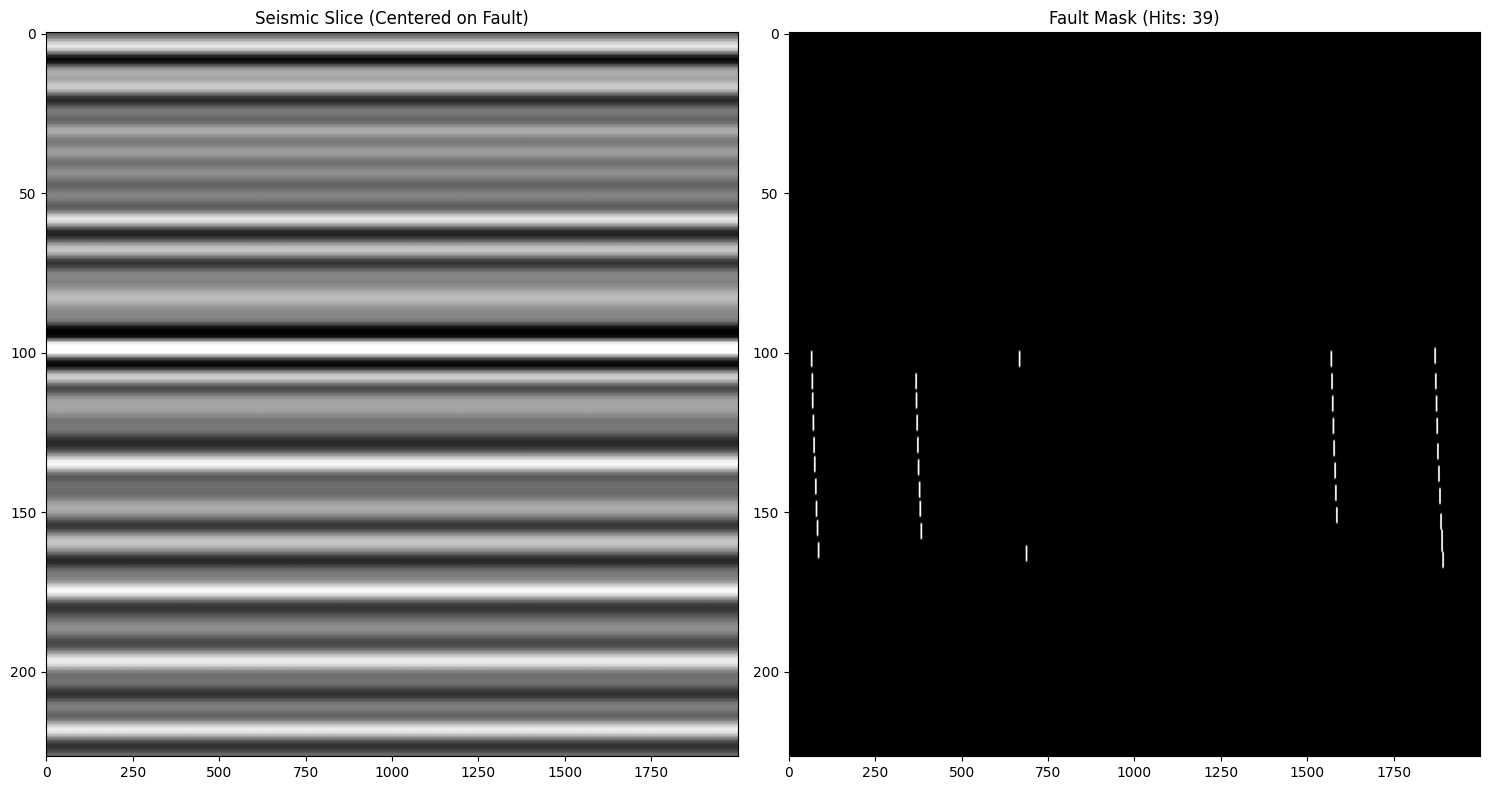

In [16]:

seismic_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'
fault_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults\Main Fault NS2'

print(f"GPS HUNTER: Searching for the Fault's exact location...")

try:
    # 1. LOAD FAULT CENTER FIRST
    fault_data = np.loadtxt(fault_path, usecols=[0, 1]) # X, Y
    fault_center = np.mean(fault_data, axis=0) # [Mean_X, Mean_Y]
    print(f"Target Location: X={fault_center[0]:.1f}, Y={fault_center[1]:.1f}")

    with segyio.open(seismic_path, ignore_geometry=True) as f:
        # 2. SCAN HEADERS TO FIND THE CLOSEST TRACE
        # We check every 100th trace to be fast (files can have millions of traces)
        step = 100 
        min_dist = float('inf')
        best_trace_idx = -1
        
        print("Scanning seismic volume ")
        
        for i in range(0, f.tracecount, step):
            # Read header
            h = f.header[i]
            sx = h[segyio.TraceField.CDP_X] / 100.0  # Remember the /100 scaling!
            sy = h[segyio.TraceField.CDP_Y] / 100.0
            
            # Distance to fault center
            dist = np.sqrt((sx - fault_center[0])**2 + (sy - fault_center[1])**2)
            
            if dist < min_dist:
                min_dist = dist
                best_trace_idx = i

        print(f"FOUND IT! Closest Trace Index: {best_trace_idx}")
        print(f"Distance: {min_dist:.1f} meters")

        # 3. DEFINE THE SLICE WINDOW
        # We grab 2000 traces AROUND the best match
        start_idx = max(0, best_trace_idx - 1000)
        end_idx = min(f.tracecount, best_trace_idx + 1000)
        
        print(f"Extracting Slice: {start_idx} to {end_idx}")

        # 4. LOAD THE DATA (With strict Lists to fix generator bug)
        traces_list = list(f.trace[start_idx:end_idx])
        seismic_img = np.array(traces_list).T 
        
        # Load Coordinates for this slice
        x_coords = [f.header[i][segyio.TraceField.CDP_X] / 100.0 for i in range(start_idx, end_idx)]
        y_coords = [f.header[i][segyio.TraceField.CDP_Y] / 100.0 for i in range(start_idx, end_idx)]
        trace_coords = np.column_stack((np.array(x_coords), np.array(y_coords)))
        
        # 5. VERTICAL SETUP (From your screenshots)
        # We use the Start Time found in your headers
        h0 = f.header[0]
        start_time = h0[segyio.TraceField.DelayRecordingTime] # Should be ~1398
        sample_rate = segyio.tools.dt(f) / 1000.0
        
        # 6. PAINT THE MASK
        print("Painting Mask...")
        mask_img = np.zeros_like(seismic_img)
        fault_data_full = np.loadtxt(fault_path, usecols=[0, 1, 3]) # X, Y, Time
        
        hits = 0
        tolerance = 100.0 # Wide tolerance to catch nearby points
        
        for fx, fy, ftime in fault_data_full:
            dists = np.sqrt(np.sum((trace_coords - np.array([fx, fy]))**2, axis=1))
            min_dist_idx = np.argmin(dists)
            
            if dists[min_dist_idx] < tolerance:
                # Vertical Correction
                rel_time = ftime - start_time
                sample_idx = int(rel_time / sample_rate)
                
                if 0 <= sample_idx < mask_img.shape[0]:
                    # Draw a nice big blob (4x4)
                    r, c = sample_idx, min_dist_idx
                    mask_img[max(0,r-2):min(r+3, mask_img.shape[0]), max(0,c-2):min(c+3, mask_img.shape[1])] = 1
                    hits += 1

        print(f"Painted {hits} fault points.")

        # 7. VISUALIZE
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
        
        vm = np.percentile(seismic_img, 98)
        ax1.imshow(seismic_img, cmap='gray', vmin=-vm, vmax=vm, aspect='auto')
        ax1.set_title(f"Seismic Slice (Centered on Fault)")
        
        ax2.imshow(mask_img, cmap='gray', aspect='auto')
        ax2.set_title(f"Fault Mask (Hits: {hits})")
        
        plt.tight_layout()
        plt.show()

except Exception as e:
    print("Error:", e)

In [17]:
#You want to convert raw SEG-Y seismic data and fault sticks into a set of aligned image-mask pairs for ML training.
#Each image: a 2D seismic slice.
#Each mask: same size, with pixels labeled 1 where faults exist.
import cv2


seismic_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'
fault_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults\Main Fault NS2'

# Create output directories
os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)


try:
    # Load Fault Data Once (Optimization)
    fault_data_full = np.loadtxt(fault_path, usecols=[0, 1, 3]) # X, Y, Time
    print(f"Loaded {len(fault_data_full)} fault points.")

    with segyio.open(seismic_path, ignore_geometry=True) as f:
        # Get Geometry Info
        h0 = f.header[0]
        start_time = h0[segyio.TraceField.DelayRecordingTime]
        sample_rate = segyio.tools.dt(f) / 1000.0
        
        # We need to map "Trace Index" to "Inline Number" to loop cleanly
        # Let's verify how many traces per Inline (approx)
        # Assuming the file is sorted by Inline, we can jump in chunks.
        total_traces = f.tracecount
        traces_per_image = 1000  # Width of your training images
        step_size = 500          # Overlap (Stride)
        
        saved_count = 0
        
        # LOOP through the volume
        print("Scanning volume in chunks...")
        
        for start_idx in range(0, total_traces, step_size):
            end_idx = min(start_idx + traces_per_image, total_traces)
            
            # 1. READ HEADERS (To check location)
            # We check the middle trace of this chunk to see if it's near a fault
            mid = (start_idx + end_idx) // 2
            h_mid = f.header[mid]
            mx = h_mid[segyio.TraceField.CDP_X] / 100.0
            my = h_mid[segyio.TraceField.CDP_Y] / 100.0
            
            # Check: Is there ANY fault point within 500m of this chunk?
            # (This filters out the empty 90% of the volume)
            dist_to_faults = np.sqrt((fault_data_full[:,0] - mx)**2 + (fault_data_full[:,1] - my)**2)
            if np.min(dist_to_faults) > 1000:
                continue # Skip this chunk, it's too far away
                
            # 2. EXTRACT SEISMIC
            traces_list = list(f.trace[start_idx:end_idx])
            seismic_img = np.array(traces_list).T
            
            # Normalize seismic (Critical for Neural Networks!)
            vm = np.percentile(seismic_img, 98)
            if vm == 0: continue
            seismic_norm = np.clip(seismic_img, -vm, vm) / vm
            # Rescale to 0-255 for saving as PNG
            seismic_uint8 = ((seismic_norm + 1) * 127.5).astype(np.uint8)

            # 3. GENERATE MASK
            mask_img = np.zeros_like(seismic_img)
            
            # Get coords for this chunk
            x_coords = [f.header[i][segyio.TraceField.CDP_X] / 100.0 for i in range(start_idx, end_idx)]
            y_coords = [f.header[i][segyio.TraceField.CDP_Y] / 100.0 for i in range(start_idx, end_idx)]
            trace_coords = np.column_stack((np.array(x_coords), np.array(y_coords)))
            
            hits = 0
            tolerance = 75.0
            
            # Filter fault points to only those nearby (Optimization)
            # We only check points that passed the distance check earlier
            relevant_points = fault_data_full[dist_to_faults < 2000]
            
            for fx, fy, ftime in relevant_points:
                dists = np.sqrt(np.sum((trace_coords - np.array([fx, fy]))**2, axis=1))
                min_dist_idx = np.argmin(dists)
                
                if dists[min_dist_idx] < tolerance:
                    rel_time = ftime - start_time
                    sample_idx = int(rel_time / sample_rate)
                    
                    if 0 <= sample_idx < mask_img.shape[0]:
                        # Draw dots
                        r, c = sample_idx, min_dist_idx
                        # Make them slightly thicker for the AI
                        mask_img[max(0,r-1):min(r+2, mask_img.shape[0]), max(0,c-1):min(c+2, mask_img.shape[1])] = 1
                        hits += 1
            
            # 4. SAVE (Only if we found faults)
            if hits > 20: # Ensure substantial fault content
                img_filename = f"dataset/images/slice_{start_idx}.png"
                mask_filename = f"dataset/masks/slice_{start_idx}.png"
                
                # Save using OpenCV
                cv2.imwrite(img_filename, seismic_uint8)
                cv2.imwrite(mask_filename, (mask_img * 255).astype(np.uint8))
                
                saved_count += 1
                if saved_count % 10 == 0:
                    print(f"Savedd {saved_count} pairs so far...")
                
                if saved_count >= 100: # Stop after 100 images for now (Test Run)
                    break

    print(f"\nDONE! Generated {saved_count} training pairs.")
    print("Check the 'dataset' folder in your project directory.")

except Exception as e:
    print("Error:", e)

Loaded 440 fault points.
Scanning volume in chunks...
Savedd 10 pairs so far...

DONE! Generated 12 training pairs.
Check the 'dataset' folder in your project directory.


In [18]:

seismic_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'
fault_path = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults\Main Fault NS2'

# Create output directories
os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)

print(f"STARTING MASS PRODUCTION")

try:
    # Load Fault Data
    fault_data_full = np.loadtxt(fault_path, usecols=[0, 1, 3]) 
    print(f"   Loaded {len(fault_data_full)} fault points.")

    with segyio.open(seismic_path, ignore_geometry=True) as f:
        # Get Geometry Info
        h0 = f.header[0]
        start_time = h0[segyio.TraceField.DelayRecordingTime]
        sample_rate = segyio.tools.dt(f) / 1000.0
        
        total_traces = f.tracecount
        traces_per_image = 1000  
        
        # --- KEY CHANGE: SMALLER STRIDE (More Overlap) ---
        step_size = 50  # Jump only 50 traces at a time (Sliding Window)
        
        saved_count = 0
        
        print(f"   Scanning volume with Stride={step_size}...")
        
        for start_idx in range(0, total_traces, step_size):
            end_idx = min(start_idx + traces_per_image, total_traces)
            
            # Stop if we hit the end of the file
            if end_idx - start_idx < traces_per_image:
                break

            # 1. FAST FILTER
            mid = (start_idx + end_idx) // 2
            h_mid = f.header[mid]
            mx = h_mid[segyio.TraceField.CDP_X] / 100.0
            my = h_mid[segyio.TraceField.CDP_Y] / 100.0
            
            dist_to_faults = np.sqrt((fault_data_full[:,0] - mx)**2 + (fault_data_full[:,1] - my)**2)
            
            # If fault is too far, SKIP immediately
            if np.min(dist_to_faults) > 1200:
                continue 
                
            # 2. EXTRACT SEISMIC
            traces_list = list(f.trace[start_idx:end_idx])
            seismic_img = np.array(traces_list).T
            
            vm = np.percentile(seismic_img, 98)
            if vm == 0: continue
            seismic_norm = np.clip(seismic_img, -vm, vm) / vm
            
            # 3. GENERATE MASK
            mask_img = np.zeros_like(seismic_img)
            
            x_coords = [f.header[i][segyio.TraceField.CDP_X] / 100.0 for i in range(start_idx, end_idx)]
            y_coords = [f.header[i][segyio.TraceField.CDP_Y] / 100.0 for i in range(start_idx, end_idx)]
            trace_coords = np.column_stack((np.array(x_coords), np.array(y_coords)))
            
            hits = 0
            tolerance = 85.0 # Slightly relaxed tolerance
            
            # Optimization: Check only relevant points
            relevant_points = fault_data_full[dist_to_faults < 2000]
            
            for fx, fy, ftime in relevant_points:
                dists = np.sqrt(np.sum((trace_coords - np.array([fx, fy]))**2, axis=1))
                min_dist_idx = np.argmin(dists)
                
                if dists[min_dist_idx] < tolerance:
                    rel_time = ftime - start_time
                    sample_idx = int(rel_time / sample_rate)
                    
                    if 0 <= sample_idx < mask_img.shape[0]:
                        r, c = sample_idx, min_dist_idx
                        # Thicker lines for better training
                        mask_img[max(0,r-1):min(r+2, mask_img.shape[0]), max(0,c-2):min(c+3, mask_img.shape[1])] = 1
                        hits += 1
            
            # 4. SAVE 
            # We want slices that have visible faults (hits > 15)
            if hits > 15: 
                img_filename = f"dataset/images/slice_{start_idx}.png"
                mask_filename = f"dataset/masks/slice_{start_idx}.png"
                
                plt.imsave(img_filename, seismic_norm, cmap='gray')
                plt.imsave(mask_filename, mask_img, cmap='gray')
                
                saved_count += 1
                if saved_count % 50 == 0:
                    print(f"Saved {saved_count} pairs so far...")

    print(f"\nDONE! Generated {saved_count} training pairs.")
    print(" Next Step: Open the 'dataset/images' folder and verify you have 100+ files.")

except Exception as e:
    print(" Error:", e)

STARTING MASS PRODUCTION
   Loaded 440 fault points.
   Scanning volume with Stride=50...
Saved 50 pairs so far...
Saved 100 pairs so far...
Saved 150 pairs so far...
Saved 200 pairs so far...
Saved 250 pairs so far...
Saved 300 pairs so far...
Saved 350 pairs so far...

DONE! Generated 370 training pairs.
 Next Step: Open the 'dataset/images' folder and verify you have 100+ files.


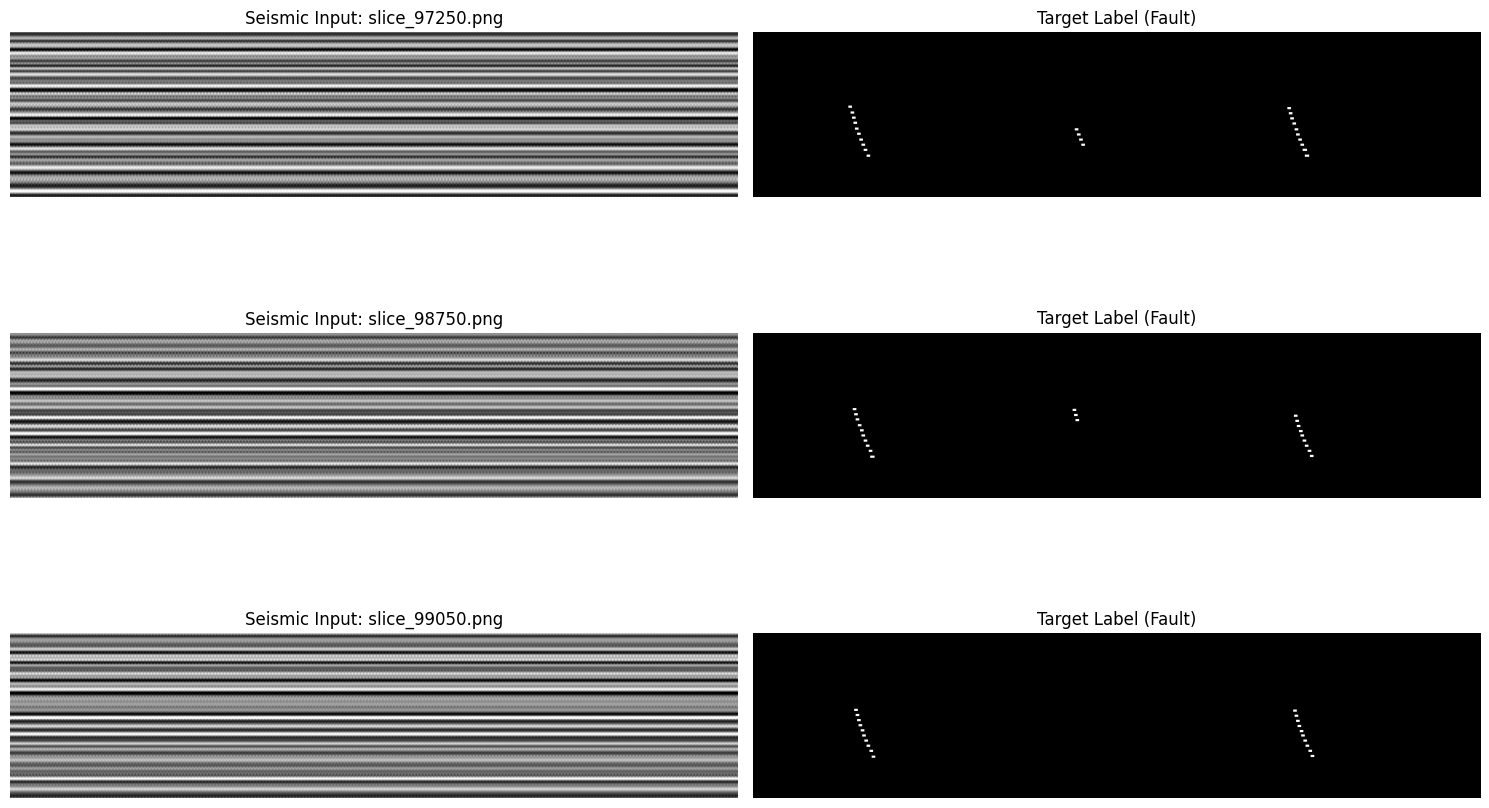

In [21]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Point to your new folders
image_folder = "dataset/images"
mask_folder = "dataset/masks"

# Get list of files
files = os.listdir(image_folder)

# Pick 3 random files to inspect
random_files = random.sample(files, 3)

plt.figure(figsize=(15, 10))

for i, filename in enumerate(random_files):
    # Read Image and Mask
    img_path = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, filename)
    
    # Read as grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Plot Image
    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Seismic Input: {filename}")
    plt.axis('off')
    
    # Plot Mask
    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Target Label (Fault)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:

base_folder = "dataset_clean" 
os.makedirs(f"{base_folder}/images", exist_ok=True)
os.makedirs(f"{base_folder}/masks", exist_ok=True)

print(f"STARTING MASS PRODUCTION (High Density Mode)...")
print(f"Saving to: {base_folder}/")

try:
    # Load Fault Data
    fault_data_full = np.loadtxt(fault_path, usecols=[0, 1, 3]) 
    print(f"   Loaded {len(fault_data_full)} fault points.")

    with segyio.open(seismic_path, ignore_geometry=True) as f:
        # Get Geometry Info
        h0 = f.header[0]
        start_time = h0[segyio.TraceField.DelayRecordingTime]
        sample_rate = segyio.tools.dt(f) / 1000.0
        
        total_traces = f.tracecount
        traces_per_image = 1000  
        
        # Stride = 50 (High Overlap)
        step_size = 50  
        
        saved_count = 0
        
        print(f"   Scanning volume with Stride={step_size}...")
        
        for start_idx in range(0, total_traces, step_size):
            end_idx = min(start_idx + traces_per_image, total_traces)
            
            # Stop if we hit the end of the file
            if end_idx - start_idx < traces_per_image:
                break

            # 1. FAST FILTER
            mid = (start_idx + end_idx) // 2
            h_mid = f.header[mid]
            mx = h_mid[segyio.TraceField.CDP_X] / 100.0
            my = h_mid[segyio.TraceField.CDP_Y] / 100.0
            
            dist_to_faults = np.sqrt((fault_data_full[:,0] - mx)**2 + (fault_data_full[:,1] - my)**2)
            
            # If fault is too far, SKIP immediately
            if np.min(dist_to_faults) > 1200:
                continue 
                
            # 2. EXTRACT SEISMIC
            traces_list = list(f.trace[start_idx:end_idx])
            seismic_img = np.array(traces_list).T
            
            
            seismic_img = np.nan_to_num(seismic_img, nan=0.0, posinf=0.0, neginf=0.0)
            
            # 2. Use Absolute value for percentile (better contrast)
            vm = np.percentile(np.abs(seismic_img), 98)
            
            if vm == 0: continue
            seismic_norm = np.clip(seismic_img, -vm, vm) / vm
            
            # 3. GENERATE MASK
            mask_img = np.zeros_like(seismic_img)
            
            x_coords = [f.header[i][segyio.TraceField.CDP_X] / 100.0 for i in range(start_idx, end_idx)]
            y_coords = [f.header[i][segyio.TraceField.CDP_Y] / 100.0 for i in range(start_idx, end_idx)]
            trace_coords = np.column_stack((np.array(x_coords), np.array(y_coords)))
            
            hits = 0
            tolerance = 85.0 
            
            # Optimization: Check only relevant points
            relevant_points = fault_data_full[dist_to_faults < 2000]
            
            for fx, fy, ftime in relevant_points:
                dists = np.sqrt(np.sum((trace_coords - np.array([fx, fy]))**2, axis=1))
                min_dist_idx = np.argmin(dists)
                
                if dists[min_dist_idx] < tolerance:
                    rel_time = ftime - start_time
                    sample_idx = int(rel_time / sample_rate)
                    
                    if 0 <= sample_idx < mask_img.shape[0]:
                        r, c = sample_idx, min_dist_idx
                        # Thicker lines for better training
                        mask_img[max(0,r-1):min(r+2, mask_img.shape[0]), max(0,c-2):min(c+3, mask_img.shape[1])] = 1
                        hits += 1
            
            # 4. SAVE 
            if hits > 15: 
                img_filename = f"{base_folder}/images/slice_{start_idx}.png"
                mask_filename = f"{base_folder}/masks/slice_{start_idx}.png"
                
                plt.imsave(img_filename, seismic_norm, cmap='gray')
                plt.imsave(mask_filename, mask_img, cmap='gray')
                
                saved_count += 1
                if saved_count % 50 == 0:
                    print(f"Saved {saved_count} pairs so far...")

    print(f"\nDONE! Generated {saved_count} training pairs.")
    print(f"Check the '{base_folder}/images' folder.")

except Exception as e:
    print("Error:", e)

STARTING MASS PRODUCTION (High Density Mode)...
Saving to: dataset_clean/
   Loaded 440 fault points.
   Scanning volume with Stride=50...
Saved 50 pairs so far...
Saved 100 pairs so far...
Saved 150 pairs so far...
Saved 200 pairs so far...
Saved 250 pairs so far...
Saved 300 pairs so far...
Saved 350 pairs so far...

DONE! Generated 370 training pairs.
Check the 'dataset_clean/images' folder.


In [24]:

base_folder = "dataset_final" 
os.makedirs(f"{base_folder}/images", exist_ok=True)
os.makedirs(f"{base_folder}/masks", exist_ok=True)

print(f"STARTING FINAL PRODUCTION MODE...")
print(f"Saving to new folder: {base_folder}/")

try:
    # Load Fault Data
    fault_data_full = np.loadtxt(fault_path, usecols=[0, 1, 3]) 
    print(f"   Loaded {len(fault_data_full)} fault points.")

    with segyio.open(seismic_path, ignore_geometry=True) as f:
        # Get Geometry Info
        h0 = f.header[0]
        start_time = h0[segyio.TraceField.DelayRecordingTime]
        sample_rate = segyio.tools.dt(f) / 1000.0
        
        total_traces = f.tracecount
        traces_per_image = 1000  
        step_size = 50  # High Density Overlap
        
        saved_count = 0
        
        print(f"Scanning volume with Stride={step_size}...")
        
        for start_idx in range(0, total_traces, step_size):
            end_idx = min(start_idx + traces_per_image, total_traces)
            
            if end_idx - start_idx < traces_per_image: break

            # 1. FAST FILTER (Skip empty areas)
            mid = (start_idx + end_idx) // 2
            h_mid = f.header[mid]
            mx = h_mid[segyio.TraceField.CDP_X] / 100.0
            my = h_mid[segyio.TraceField.CDP_Y] / 100.0
            
            dist_to_faults = np.sqrt((fault_data_full[:,0] - mx)**2 + (fault_data_full[:,1] - my)**2)
            if np.min(dist_to_faults) > 1200: continue 
                
            # 2. EXTRACT SEISMIC
            traces_list = list(f.trace[start_idx:end_idx])
            seismic_img = np.array(traces_list).T
            
           
            # Replace NaNs with 0
            seismic_img = np.nan_to_num(seismic_img, nan=0.0)
            
            # Calculate amplitude of every trace
            trace_amps = np.max(np.abs(seismic_img), axis=0)
            median_amp = np.median(trace_amps)
            
            # If a trace is 10x louder than the median(Set to 0)
            # This deletes the "Spikes" that make images black
            bad_trace_mask = trace_amps > (10 * median_amp)
            if np.any(bad_trace_mask):
                seismic_img[:, bad_trace_mask] = 0.0
            
            # (IQR) 
            # Instead of 98th percentile, we use IQR which ignores outliers
            q25, q75 = np.percentile(seismic_img, [25, 75])
            iqr = q75 - q25
            
            if iqr == 0: continue # Skip flat images
            
            # Define max value as Q75 + 1.5 * IQR (Standard Statistical Threshold)
            vm = q75 + (2.0 * iqr) 
            
            # Clip and Normalize
            seismic_norm = np.clip(seismic_img, -vm, vm) / vm
            
            # Convert to 0-255
            seismic_uint8 = ((seismic_norm + 1) * 127.5).astype(np.uint8)

            # 3. GENERATE MASK
            mask_img = np.zeros_like(seismic_img)
            
            x_coords = [f.header[i][segyio.TraceField.CDP_X] / 100.0 for i in range(start_idx, end_idx)]
            y_coords = [f.header[i][segyio.TraceField.CDP_Y] / 100.0 for i in range(start_idx, end_idx)]
            trace_coords = np.column_stack((np.array(x_coords), np.array(y_coords)))
            
            hits = 0
            tolerance = 85.0 
            
            relevant_points = fault_data_full[dist_to_faults < 2000]
            
            for fx, fy, ftime in relevant_points:
                dists = np.sqrt(np.sum((trace_coords - np.array([fx, fy]))**2, axis=1))
                min_dist_idx = np.argmin(dists)
                
                if dists[min_dist_idx] < tolerance:
                    rel_time = ftime - start_time
                    sample_idx = int(rel_time / sample_rate)
                    
                    if 0 <= sample_idx < mask_img.shape[0]:
                        r, c = sample_idx, min_dist_idx
                        # Draw fault line
                        mask_img[max(0,r-1):min(r+2, mask_img.shape[0]), max(0,c-2):min(c+3, mask_img.shape[1])] = 1
                        hits += 1
            
            # 4. SAVE 
            if hits > 20: 
                img_filename = f"{base_folder}/images/slice_{start_idx}.png"
                mask_filename = f"{base_folder}/masks/slice_{start_idx}.png"
                
                # Save using OpenCV
                cv2.imwrite(img_filename, seismic_uint8)
                cv2.imwrite(mask_filename, (mask_img * 255).astype(np.uint8))
                
                saved_count += 1
                if saved_count % 50 == 0:
                    print(f" Saved {saved_count} pairs so far...")
                
                # LIMIT for safety (remove this if you want thousands of images)
                if saved_count >= 200: 
                   break

    print(f"\nDONE! Generated {saved_count} training pairs.")
    print(f"Check the '{base_folder}/images' folder.")

except Exception as e:
    print("Error:", e)

STARTING FINAL PRODUCTION MODE...
Saving to new folder: dataset_final/
   Loaded 440 fault points.
Scanning volume with Stride=50...
 Saved 50 pairs so far...
 Saved 100 pairs so far...
 Saved 150 pairs so far...

DONE! Generated 185 training pairs.
Check the 'dataset_final/images' folder.
